# Réseaux de neurones : Echo State Network

## Une brève introduction

<p style="text-align:justify">Depuis l'élaboration du perceptron par Frank Rosenblatt en 1957, de nombreux modèles de réseaux de neurones ont émergé. Un <b>echo state network</b> est un réseau de neurones récurrents (c'est-à-dire dont la trajectoire n'est pas forcément linéaire, et donc possédant une mémoire) dont le réservoir est composé de neurones entre lesquels les poids sont générés aléatoirement. Seuls les poids des sorties (donc entre le réservoir et la sortie) peuvent être modifiés, via un apprentissage supervisé : on va comparer la sortie du réseau avec une sortie « cible ». Nous allons ici développer un modèle d'ESN, issu d'un article de Mantas Lukoševičius.</p>

In [19]:
%matplotlib inline

## Importation des modules

<p style="text-align:justify">Commençons par importer les modules dont nous avons besoin. Outre la commande <b>%matplotlib inline</b> qui permet d'afficher les courbes directement dans le notebook, nous allons avoir besoin de <b>numpy</b> (module numérique destiné à la manipulation de vecteurs et de matrices), de <b>matplotlib</b> (pour tracer les courbes, donc), de <b>scipy</b> (la méthode linalg nous permettra d'importer des fonctions d'algèbre linéaire), ainsi que de widgets issus de <b>IPython</b>, qui nous permettront de rendre les courbes interactives à l'aide de curseurs permettant de modifier les variables en temps réel.</p>

In [20]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukoševičius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

## Remise à zéro de l'aléatoire

Ensuite, on va initier une première valeur pseudo-aléatoire en fonction du moment auquel est lancé le programme. Cela permet de s'assurer que deux exécutions du programme ne donneront pas le même résultat.

In [21]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Création d'une classe "Réseau"

On crée une classe <i>Réseau</i>. Un objet appartenant à cette classe contiendra, par défaut, quatre attributs :
<ul><li><b>initLen</b> : nombre d'itérations pour l'initalisation. Durant cette phase, il ne se passe rien : cela permet de commencer l'entraînement avec une valeur intermédiaire plutôt qu'avec une des premières valeurs des données ;</li>
<li><b>trainLen</b> : nombre d'itérations pour l'entraînement. Le réseau va modifier les poids entre le réservoir et la sortie de façon à pouvoir prédire ou générer une série ;</li>
<li><b>testLen</b> : nombre d'itérations pour le test ;</li>
<li><b>data</b> : fichier de données. Le fichier proposé ici contient les 10 000 premières itérations d'une série chaotique de Mackey-Glass. Une série chaotique est une suite issue d'une fonction, pour laquelle une modification minime du nombre de départ a des conséquences importantes sur les termes suivants.</li></ul>

In [22]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.data = np.loadtxt("MackeyGlass_t17.txt")

nw = Network()

## Affichage dynamique d'un échantillon de données

Nous allons maintenant afficher une partie des données du fichier <i>data</i>, en traçant les 2000 premières itérations. Vous pouvez modifier le nombre d'itérations à afficher en déplaçant le curseur.

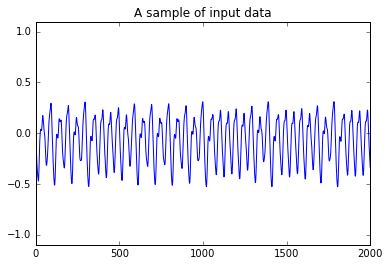

In [23]:
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(nw.data[0:int(f)])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    
interact(plot_figure, f=FloatSlider(value=2000,min=1000,max=10000,step=1000,continuous_update=False));

## Variables 

Créons désormais notre réservoir. De base, celui-ci contient 300 neurones (<b>resSize</b>), l'entrée et la sortie sont de taille 1 (<b>inSize et outSize</b>). Cela nous donne un réseau sous cette forme : <img src="Reservoir.png"></img>
Les neurones en entrée sont connectés aux neurones du réservoir. On représente donc les poids de chacune des connexions par une matrice <b style="color:#99cc00">W<sub>in</sub></b> (de taille inSize × resSize). De même, les connexions des neurones de la sortie sont représentées par la matrice <b style="color:#ff0000">W<sub>out</sub></b> (de taille resSize × outSize). Enfin, dans le réservoir, chaque neurone est lié à tous les autres neurones du réservoir (matrice <b style="color:#ffcc00">W</b>, de taille resSize × resSize).

Les valeurs des neurones du réservoir sont enregistrées au cours du temps dans une matrice <b style="color:#ffcc00">x</b> (de taille resSize × (initLen+trainLen)). La matrice <b style="color:#00baff">X</b>, quant à elle, contient les valeurs du biais (<b style="color:#99cc00">1</b>), de l'entrée (<b style="color:#99cc00">u</b>), et des neurones du réservoir (<b style="color:#ffcc00">x</b>) au cours du temps (t). La matrice est ainsi de taille (1+inSize+resSize)×(initLen+trainLen). Enfin, on stocke les valeurs du neurone de sortie au cours du temps dans une matrice <b style="color:#ff0000">y</b>, de taille 1×(initLen+trainLen).

La matrice <b style="color:#a7008a">Y<sub>target</sub></b> correspond au valeurs « cibles » : il s'agit des valeurs de <b>data</b> situées après les itérations d'initialisation et d'entrainement. On va pouvoir comparer ces valeurs avec les sorties du réservoir.

In [24]:
nw.inSize = nw.outSize = 1 #Dimension de l'entrée et de la sortie
nw.resSize = 300 #Taille du réservoir (prédiction)
#nw.resSize = 1000 #Taille du réservoir (géneration)
nw.a = 0.3 #Taux de fuite alpha 
nw.spectral_radius = 1.25 #Rayon spectral
nw.input_scaling = 1. #Echelle de l'input
nw.reg =  1e-8 #None #Coefficient de régularisation - si None,
#on utilisera le pseudo-inverse plutôt que la régression de crête

nw.mode = 'prediction'
#nw.mode = 'generative'

#Modification de la première valeur pseudo-aléatoire : les performances du réservoir
#devraient être dans la moyenne après 20 instances aléatoires (pour les mêmes paramètres)
seed = None #42

set_seed(seed)

164420146
Seed used for random values: 164420146


164420146

## Fonctions de traçages des courbes

On définit un certain nombre de fonctions permettant de tracer des courbes un peu plus tard.

In [25]:
def plot_figure1(nw) :
    nw = calcul_reseau(nw)
    plt.figure(1).clear()
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+nw.testLen+1], 'g' )
    plt.plot( nw.Y.T, 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
        
def plot_figure1b(nw) :
    nw = calcul_reseau(nw)
    plt.figure(7).clear()
    plt.ylim([-0.2,0.2])
    plt.plot(nw.data[nw.trainLen+1:nw.trainLen+nw.testLen+1]-nw.Y[0], 'g' )
    plt.title('Target and predicted signal difference through time')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])

def plot_figure2(nw) :
    nw = calcul_reseau(nw)
    plt.figure(2).clear()
    plt.plot( nw.X[0:2,0:2000].T ) #xav
    plt.legend(["biais", "input"])
    plt.ylim([-1.1,1.1])
    plt.title('Input $\mathbf{u}(n)$ and bias for 2000 time steps')

def plot_figure3(nw,nb) :
    nw = calcul_reseau(nw)
    plt.figure(3).clear()
    plt.plot( nw.X[2:2+nb,0:200].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to '+str(nb-1)+' for 200 time steps')

def plot_figure4(nw,num) :
    nw = calcul_reseau(nw)
    plt.figure(4).clear()
    plt.plot( nw.X[2+num,:].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neuron ID '+str(num)+' for all time steps')

def plot_figure5(nw,l) :
    nw = calcul_reseau(nw)
    plt.figure(5).clear()
    print(nw.X.shape)
    plt.plot( nw.X[2:,0:l].T )
    plt.ylim([-1.1,1.1])
    plt.title('All reservoir activations $\mathbf{x}(n)$ for '+str(l)+' time steps')

def plot_figure6(nw) :
    nw = calcul_reseau(nw)
    plt.figure(6).clear()
    plt.bar( range(1+nw.inSize+nw.resSize), nw.Wout.T )
    plt.title('Output weights $\mathbf{W}^{out}$')

## Calcul du réseau en fonction des paramètres

On commence par générer aléatoirement les poids en entrée <b style="color:#99cc00">W<sub>in</sub></b>, ainsi que les poids <b style="color:#ffcc00">W</b> entre les neurones du réservoir. Ensuite, on crée les matrices des neurones décrits plus tôt : <b style="color:#ffcc00">x</b>, <b style="color:#a7008a">Y<sub>target</sub></b> et <b style="color:#00baff">X</b>.

In [26]:
def initialisation(nw) :

    #Poids
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    
    #Matrices
    #Matrice des états collectés (1,u,x) au cours du temps
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    #Matrice de sortie cible
    nw.Ytarget = nw.data[None,nw.initLen+1:nw.trainLen+1]

    #Vecteur des états du réservoir
    nw.x = np.zeros((nw.resSize,1))  
    
    return(nw)

On calcule le rayon spectral de la matrice <b style="color:#ffcc00">W</b> des poids du réservoir, qui correspond à la valeur absolue des valeurs propres la plus élevée. Ensuite, on redimensionne les poids en fonction de ce rayon spectral.
Plus le rayon spectral est élevé, plus le système est apte à se souvenir d'entrées plus longues.

In [27]:
def calcul_rayon_spectral(nw):
    # Option 1 - direct scaling (quick&dirty, reservoir-specific):
    #W *= 0.135
    
    # Option 2 - normalizing and setting spectral radius (correct, slow):
    print('Calcul du rayon spectral',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    #np_rhoW = max(abs(np.linalg.eig(W)[0]))
    #print("Difference between scipy and numpy .eig() method: scipy="+str(rhoW)+" numpy="+str(np_rhoW)
    print('Effectué.')
    nw.W *= nw.spectral_radius / rhoW
    
    return(nw)

On passe ensuite à une phase d'apprentissage, qui va durer un nombre d'itérations défini (<b>trainLen</b>). En entrée, on utilise les données issues du fichier <i>data</i>. A chaque itération, on modifie la valeur de la donnée de chaque neurone du réservoir en fonction des poids <b style="color:#99cc00">W<sub>in</sub></b>. On se sert de la formule suivante :</br></br>
$$x_{n} = (1-\alpha)x_{n-1} + \alpha \tanh(W_{in}.u_{n-1} + W.x_{n-1})$$
Dans cette formule, le alpha agit comme un facteur de "mémoire" du réseau.
Une fois la période d'initialisation terminée (<b>initLen</b>), on commence à modifier la matrice <b style="color:#00baff">X</b>, qui va collecter les états des neurones durant la simulation : le premier neurone correspond au biais (<b style="color:#99cc00">1</b>), le second à l'entrée (<b style="color:#99cc00">u</b>), et tous les suivants aux neurones du réservoir (la matrice <b style="color:#ffcc00">x</b>) :
$$X_{n} = [1;u_{n};x_{n}]$$

In [28]:
def train_input(nw) :
    #APPRENTISSAGE
    for t in range(nw.trainLen):
        #Données en entrée, issues de data
        nw.u = nw.data[t]
        
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        #Au bout d'un certain temps, on modifie X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
            
    return(nw)

On va maintenant passer à l'entraînement des poids en sortie <b style="color:#ff0000">W<sub>out</sub></b>, en les ajustant en fonction des valeurs des neurones du réservoir (<b style="color:#00baff">X</b>) et des valeurs de sortie cibles (<b style="color:#a7008a">Y<sub>target</sub></b>) :
$$W_{out} = (Y_{target}.X^{T}).(X.X^{T} + reg.I)^{-1}$$


In [29]:
def train_output(nw) :
    # train the output
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # Régression de crête (régression linéaire avec régularisation)
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
        ### Just if you want to try the difference between scipy.linalg and numpy.linalg 
        ### which does not give the same results. For more info, see :
        ### https://www.scipy.org/scipylib/faq.html#why-both-numpy-linalg-and-scipy-linalg-what-s-the-difference
        # np_Wout = np.dot(np.dot(Yt,X_T), np.linalg.inv(np.dot(X,X_T) + \
        # reg*np.eye(1+inSize+resSize) ) )
        # print("Difference between scipy and numpy .inv() method:\n\tscipy_mean_Wout="+\
        # str(np.mean(Wout))+"\n\tnumpy_mean_Wout="+str(np.mean(np_Wout))
    else:
        # use pseudo inverse
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )
        
    return(nw)

L'entrainement terminé, on peut maintenant passer au test du réseau.
En mode génératif, on va, à chaque itération, se servir de la sortie précédente pour générer la suivante. En mode prédictif, on va se servir de la donnée réelle afin de tenter de prédire la sortie suivante.

In [30]:
def test(nw) :
    # run the trained ESN in a generative mode. no need to initialize here, 
    # because x is initialized with training data and we continue from there.
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")

    return(nw)

In [31]:
def calcul_erreur(nw) :
    # compute MSE for the first errorLen time steps
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [32]:
def calcul_reseau(nw) :
    nw = initialisation(nw)
    nw = calcul_rayon_spectral(nw)
    nw = train_input(nw)
    nw = train_output(nw)
    nw = test(nw) 
    nw = calcul_erreur(nw)
    return(nw)

## Graphique 1 : Comparaison entre sorties attendues et sorties estimées

Calcul du rayon spectral Effectué.
MSE = 1.44674122391e-05


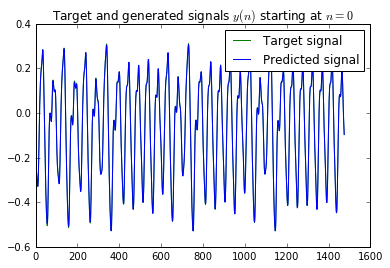

In [35]:
var1 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=5000, step=1, description='trainLen')
var4 = FloatSlider(value=2000, min=0, max=5000, step=1, description='testLen')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])

def trace_graph1(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    plot_figure1(nw)
    
valid.on_click(trace_graph1)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(valid)

Calcul du rayon spectral Effectué.
MSE = 1.6475437555e-07


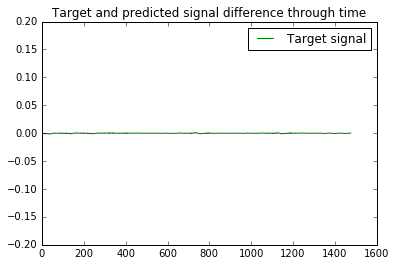

In [39]:
plot_figure1b(nw)

## Graphique 2 : Affichage des données en entrée

On affiche, pour les 2000 premières itérations, les valeurs en entrée et le biais (toujours égal à 1).

Calcul du rayon spectral Effectué.
MSE = 9.12275010282e-06


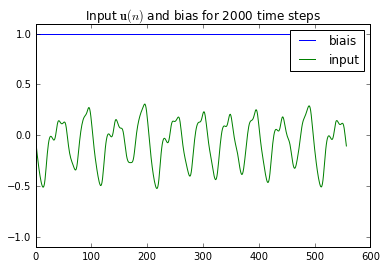

In [40]:
plot_figure2(nw)

## Graphique 3 : Affichage des activations des neurones (total)

In [41]:
var4 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var5 = FloatSlider(value=10, min=1, max=nw.resSize, step=1, description='nombre de neurones')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])

def trace_graph3(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var4.value)
    nb=int(var5.value)
    plot_figure3(nw,nb)
    
valid.on_click(trace_graph3)
    
display(select_mode)
display(var4)
display(var5)
display(valid)

## Graphique 4 : Affichage des activations d'un neurone unique du réservoir

In [42]:
var10 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var11 = FloatSlider(value=2, min=0, max=nw.resSize-1, step=1, description='neuron ID')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])

def trace_graph4(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var10.value)
    num=int(var11.value)
    plot_figure4(nw,num)
    
valid.on_click(trace_graph4)

display(select_mode)    
display(var10)
display(var11)
display(valid)

## Graphique 5 : Affichage de toutes les activations du réservoir

In [43]:
var13 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var14 = FloatSlider(value=300, min=0, max=2000, step=1, description='resSize')
var15 = FloatSlider(value=200, min=0, max=nw.testLen-nw.initLen, step=10, description='time steps')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='mode',
    options=['prediction', 'generative'])

def trace_graph5(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var13.value)
    nw.resSize=int(var14.value)
    l=int(var15.value)
    plot_figure5(nw,l)
    
valid.on_click(trace_graph5)
    
display(select_mode)
display(var13)
display(var14)
display(var15)
display(valid)

## Graphique 6 : Poids en sortie à la fin de la simulation

In [44]:
var16 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var17 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var18 = FloatSlider(value=1000, min=0, max=2000, step=1, description='trainLen')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='mode',
    options=['prediction', 'generative'])

def trace_graph6(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var16.value)
    nw.resSize=int(var17.value)
    nw.trainLen=int(var18.value)
    plot_figure6(nw)
    
valid.on_click(trace_graph6)

display(select_mode)
display(var16)
display(var17)
display(var18)
display(valid)